In [1]:
#!pip install torch transformers
import torch
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd


In [21]:
data = pd.read_csv('/kaggle/input/imdb-50k-reviews/IMDB Dataset.csv')

In [2]:
data["sentiment"].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [24]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import torch
from tqdm import tqdm

start_time = time.time()

# Load data
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})
reviews = data['review'].tolist()
labels = data['sentiment'].tolist()  


# Split the data into train, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(reviews, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Create torch datasets
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Move the model to the device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Validation Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch + 1}/{num_epochs} - Avg. Train Loss: {loss.item():.4f} - Avg. Val Loss: {avg_val_loss:.4f} - Val Accuracy: {accuracy:.4f}')

# Testing
model.eval()
test_loss = 0.0
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for batch in tqdm(test_loader, desc=f'Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
accuracy = correct_predictions / total_samples

print(f'Test Results - Avg. Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.4f}')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation Epoch 1/5: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Epoch 1/5 - Avg. Train Loss: 0.0284 - Avg. Val Loss: 0.1810 - Val Accuracy: 0.9285


Validation Epoch 2/5: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Epoch 2/5 - Avg. Train Loss: 0.0404 - Avg. Val Loss: 0.1928 - Val Accuracy: 0.9237


Validation Epoch 3/5: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Epoch 3/5 - Avg. Train Loss: 0.0057 - Avg. Val Loss: 0.2113 - Val Accuracy: 0.9286


Validation Epoch 4/5: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Epoch 4/5 - Avg. Train Loss: 0.0036 - Avg. Val Loss: 0.2535 - Val Accuracy: 0.9229


Validation Epoch 5/5: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Epoch 5/5 - Avg. Train Loss: 0.0018 - Avg. Val Loss: 0.2537 - Val Accuracy: 0.9286


Testing: 100%|██████████| 625/625 [01:27<00:00,  7.18it/s]

Test Results - Avg. Test Loss: 0.2437 - Test Accuracy: 0.9278


In [19]:
torch.cuda.empty_cache()


In [26]:
labels.shape

torch.Size([16])

In [25]:
# Save the entire model state dictionary
torch.save(model.state_dict(), 'sentiment_model_DistilBERT/modelooo.pth')


## Model Evaluation on our Barbie data

The data is not balanced so we did some undersampling

In [3]:
val_data = pd.read_csv('/kaggle/input/imdb-val/imdb_val.csv')
val_data["Sentiment"].value_counts()

Sentiment
1    997
0    163
Name: count, dtype: int64

In [4]:
import numpy as np
import pandas as pd

majority_class_indices = val_data[val_data['Sentiment'] == 1].index

# Randomly select a subset of indices to drop
drop_indices = np.random.choice(majority_class_indices, size=(997-163), replace=False)

# Drop the selected samples from the majority class
val_data = val_data.drop(drop_indices)


In [6]:
# Initialize a new model instance
new_model = DistilBertForSequenceClassification.from_pretrained('/kaggle/input/distilbert-base-uncased/distilbert-base-uncased', num_labels=2)


# Load the saved state dictionary
new_model.load_state_dict(torch.load('/kaggle/working/sentiment_model_DistilBERT/modelooo.pth'))

tokenizer = DistilBertTokenizer.from_pretrained('/kaggle/input/distilbert-base-uncased/distilbert-base-uncased')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
val_texts = val_data['Review'].tolist()
val_labels = val_data['Sentiment'].tolist()  # convert sentiment to numeric

# Tokenize data
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Create torch dataset for validation
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

val_dataset = ReviewDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
new_model.eval()
new_model.to('cuda')

predictions = []
true_labels = []
for batch in val_loader:
    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels = batch['labels'].to('cuda')

    with torch.no_grad():
        outputs = new_model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'F1-score: {f1}')
print(f'Confusion matrix:\n {conf_matrix}')

Accuracy: 0.8098159509202454
F1-score: 0.8176470588235294
Confusion matrix:
 [[125  38]
 [ 24 139]]


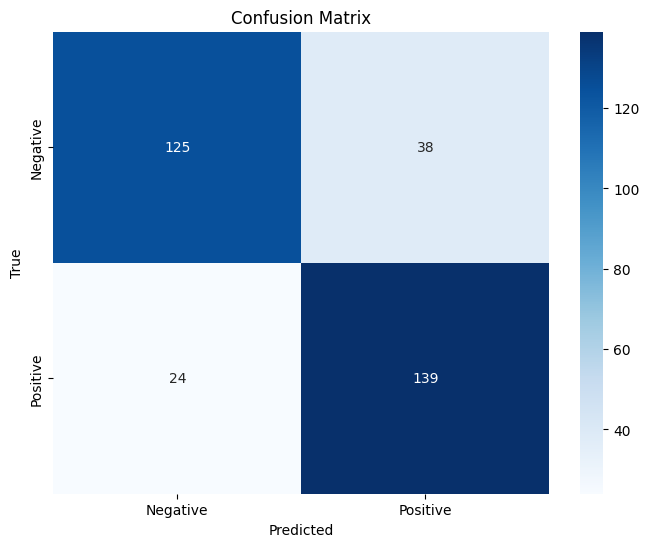

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The model seems to be performing reasonably well with a high accuracy and F1-score